# Scratchpad to study the factorization problem

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import math
import os
import pickle
import sys
from dataclasses import dataclass
from pathlib import Path
from tqdm import tqdm

sys.path.append(str(Path("..").resolve()))
save_dir = Path(".").resolve() / "results"

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from models.mlp import TransformerFeedForward
from models.normalization import RMSNorm

DEVICE = torch.device("cuda:0")
SEED = 42
RNG = np.random.default_rng(SEED)
np.random.seed(seed=SEED)
torch.manual_seed(seed=SEED)

Data Generation

In [11]:
vocab_size = 4
bsz = 2048
length = 12
sparsity_index = 5

# we create a modular addition problem on some subset of the input only
data = np.random.rand(bsz, length) // (1 / vocab_size)
targets = data[:, :sparsity_index].sum(axis=1) % vocab_size

test_bsz = 128
test_data = np.random.rand(test_bsz, length) // (1 / vocab_size)
test_targets = test_data[:, :sparsity_index].sum(axis=1) % vocab_size

In [12]:
print(f"Total number of unique sequences {vocab_size ** length}")

Total number of unique sequences 16777216


Model

In [13]:
class SoftmaxLayer(nn.Module):
    def __init__(self, emb_dim):
        super(SoftmaxLayer, self).__init__()
        self.emb_dim = emb_dim
        self.query = nn.Linear(emb_dim, 1, bias=False)
        self.value = nn.Linear(emb_dim, emb_dim, bias=False)

    def forward(self, x, verbose=False):
        # x: [bsz, seq_len, emb_dim]
        query = self.query.weight
        key = x
        value = self.value(x)

        attn = query @ key.transpose(-1, -2) / math.sqrt(self.emb_dim)
        attn = F.softmax(attn, dim=-1)
        out = (attn @ value).squeeze(1)
        if verbose:
            return out, attn.squeeze(1)
        return out

In [14]:
@dataclass
class MLPConfig:
    activation: float = "gelu"
    emb_dim: bool = None
    ffn_dim: bool = None
    ffn_bias: bool = False
    ffn_dropout: float = 0

    def __post_init__(self):
        if self.ffn_dim is None:
            self.ffn_dim = 4 * self.emb_dim


class Model(nn.Module):
    def __init__(self, emb_dim, vocab_size):
        super(Model, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, emb_dim)
        self.pos_emb = nn.Embedding(length, emb_dim)

        self.softmax = SoftmaxLayer(emb_dim)
        config = MLPConfig(
            emb_dim=emb_dim,
            ffn_dim=4 * emb_dim,
            ffn_bias=True,
            activation="gelu",
        )
        self.mlp = TransformerFeedForward(config)

        self.output = nn.Linear(emb_dim, vocab_size, bias=False)
        self.output.weight = self.token_emb.weight

        self.norm1 = RMSNorm()
        self.norm2 = RMSNorm()

    def forward(self, x, verbose=False):
        out = self.token_emb(x) + self.pos_emb.weight
        out = self.softmax(self.norm1(out), verbose=verbose)
        if verbose:
            out, attn = out
        out = out + self.mlp(self.norm2(out))
        out = self.output(out)
        if verbose:
            return out, attn
        return out

In [5]:
emb_dim = 32

X = torch.from_numpy(data.astype(int))
model = Model(emb_dim, vocab_size=4)

Training

TODO - cut the data into batches for each epochs

In [ ]:
niter = 10_000

all_losses = {}
all_accs = {}
all_test_accs = {}
all_attns = {}
# names = ['SGD', 'Adam', 'AdamLN', 'SGDLN']
names = ["Adam"]

X = torch.from_numpy(data).to(dtype=torch.long, device=DEVICE)
Y = torch.from_numpy(targets).to(dtype=torch.long, device=DEVICE)

X_test = torch.from_numpy(test_data).to(dtype=torch.long, device=DEVICE)
Y_test = torch.from_numpy(test_targets).to(dtype=torch.long, device=DEVICE)

for name in names:
    print(name, flush=True)

    # model = Model(emb_dim, vocab_size=4)
    model.to(device=DEVICE)
    if name[:3] == "SGD":
        lr = 1e-1
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
    else:
        lr = 1e-4
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = torch.zeros(niter)
    accs = torch.zeros(niter)
    test_accs = torch.zeros(niter)
    attns = torch.zeros((niter, test_bsz, length))

    for i in tqdm(range(niter)):
        optimizer.zero_grad()

        # compute loss
        score = model(X, verbose=False)
        # loss = F.cross_entropy(score.view((-1, vocab_size)), Y.view(-1))
        loss = F.cross_entropy(score.view((-1, 4)), Y.view(-1))

        loss.backward()
        optimizer.step()

        # record statistics
        with torch.no_grad():
            losses[i] = loss.item()
            accs[i] = (score.argmax(-1) == Y).float().mean()
            score_test, attn = model(X_test, verbose=True)
            test_accs[i] = (score_test.argmax(-1) == Y_test).float().mean()
            attns[i] = attn

    all_losses[name] = losses
    all_accs[name] = accs
    all_test_accs[name] = test_accs
    all_attns[name] = attns

In [ ]:
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

# save model
torch.save(model.state_dict(), save_dir / f"{name}.pt")

with open(save_dir / "losses.pkl", "wb") as f:
    pickle.dump(all_losses, f)
with open(save_dir / "accs.pkl", "wb") as f:
    pickle.dump(all_accs, f)
with open(save_dir / "attns.npy", "wb") as f:
    np.save(f, all_attns["Adam"])

In [ ]:
model

Model(
  (token_emb): Embedding(4, 32)
  (pos_emb): Embedding(12, 32)
  (softmax): SoftmaxLayer(
    (query): Linear(in_features=32, out_features=1, bias=False)
    (value): Linear(in_features=32, out_features=32, bias=False)
  )
  (mlp): TransformerFeedForward(
    (fc1): Linear(in_features=32, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=32, bias=True)
  )
  (output): Linear(in_features=32, out_features=4, bias=False)
  (norm1): RMSNorm()
  (norm2): RMSNorm()
)

In [ ]:
import matplotlib.pyplot as plt

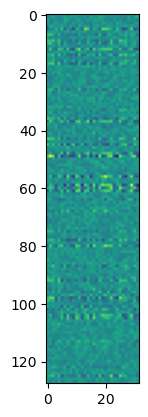

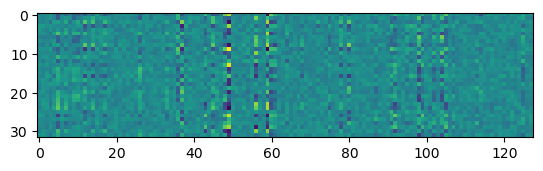

In [ ]:
plt.figure()
plt.imshow(model.mlp.fc1.weight.cpu().detach().numpy())
plt.figure()
plt.imshow(model.mlp.fc2.weight.cpu().detach().numpy())

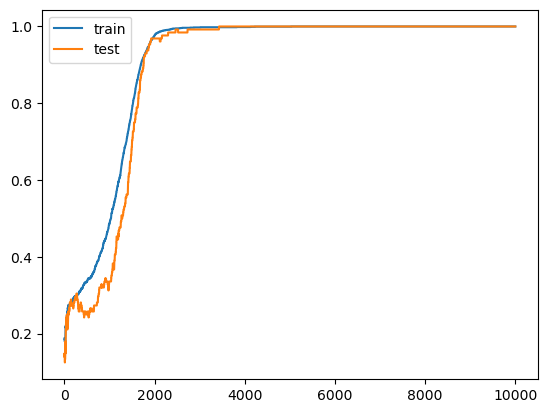

In [ ]:
import matplotlib.pyplot as plt

plt.plot(all_accs["Adam"], label="train")
plt.plot(all_test_accs["Adam"], label="test")
plt.legend()

Visualize attention evolution

In [ ]:
from pathlib import Path
import numpy as np

from visualization.graph import build_1L_graph

save_dir = Path(".").resolve() / "results"
attns = np.load(save_dir / "attns.npy", allow_pickle=True)

In [ ]:
attns.shape

(10000, 128, 12)

In [ ]:
X_test[0]

tensor([1, 0, 3, 1, 1, 1, 0, 1, 1, 3, 3, 3], device='cuda:0')

In [ ]:
X_test[1]

tensor([0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 1, 0], device='cuda:0')

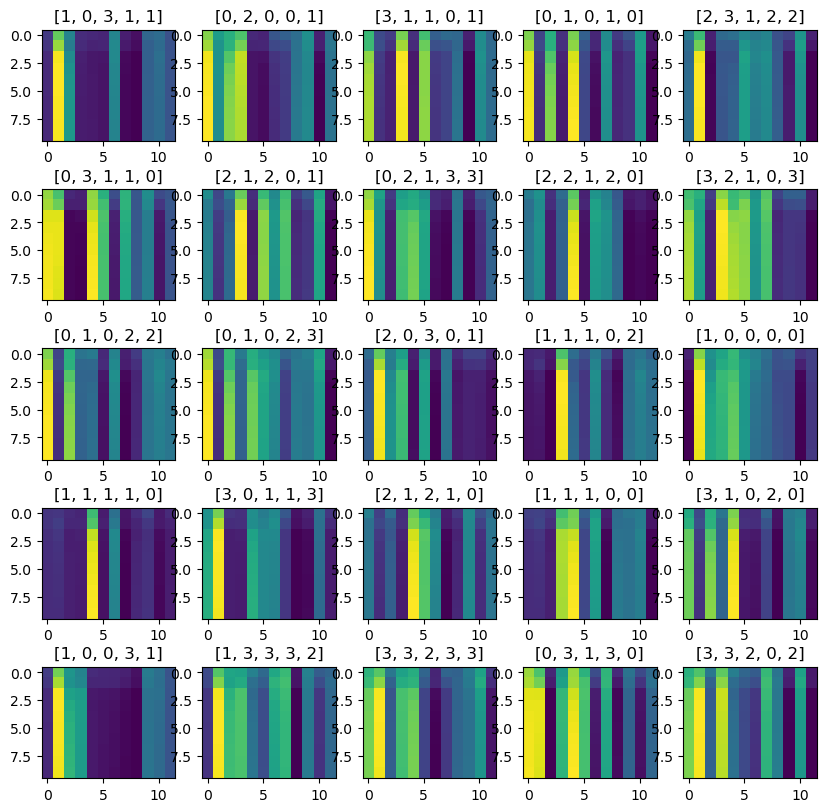

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i in range(25):
    ax[i // 5, i % 5].imshow(attns[::1000, i, :])
    ax[i // 5, i % 5].set_title(f"{X_test[i,:5].tolist()}")
# plt.colorbar()

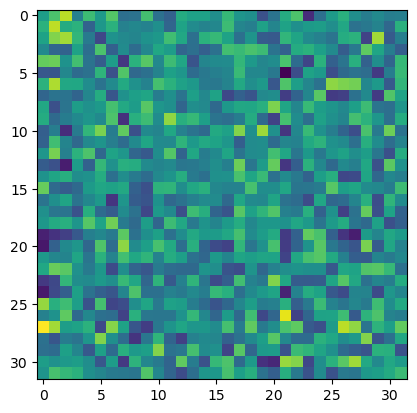

In [ ]:
plt.imshow(model.softmax.value.weight.cpu().detach().numpy())

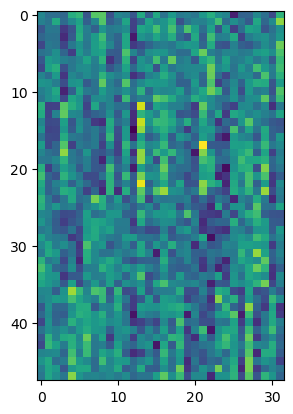

In [ ]:
embs = np.vstack([qwe for qwe in model.token_emb.weight.cpu().detach().numpy() for _ in range(12)])
plt.imshow(embs + model.pos_emb.weight.repeat(4, 1).cpu().detach().numpy())

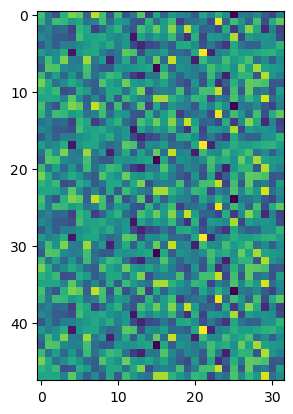

In [ ]:
plt.imshow()

In [ ]:
x = X_test[0:5]
z = model.token_emb(x) + model.pos_emb.weight
z = model.norm1(z)
query = model.softmax.query.weight
key = z
value = model.softmax.value(z)
attn = query @ key.transpose(-1, -2) / math.sqrt(model.softmax.emb_dim)
attn = F.softmax(attn, dim=-1)
out = (attn @ value).squeeze(1)
out2 = out + model.mlp(model.norm2(out))
out3 = model.output(out2)

In [ ]:
out

tensor([[ 0.0976, -0.1420,  0.0686,  0.1195,  0.0297, -0.1472,  0.1886, -0.1703,
          0.1152,  0.3015, -0.1238, -0.1751,  0.1997, -0.0939, -0.1208,  0.1845,
         -0.1805,  0.0817, -0.0200, -0.1936, -0.2985, -0.1800, -0.2270,  0.0106,
          0.0131, -0.0982,  0.0735,  0.1200, -0.0332, -0.1646,  0.1997,  0.2473],
        [-0.0385, -0.2174, -0.1494,  0.1951, -0.1238,  0.1028,  0.0085,  0.0830,
          0.1572,  0.1069,  0.1332, -0.1237,  0.1466,  0.1337, -0.0909,  0.0884,
         -0.0317,  0.2393, -0.1304,  0.1566,  0.0481, -0.0835, -0.1887,  0.0734,
          0.1935, -0.2605, -0.1277, -0.0702,  0.0310, -0.0092, -0.1210,  0.1072],
        [ 0.0508, -0.1683,  0.0893,  0.0870, -0.0685, -0.1601,  0.1476, -0.1824,
          0.1348,  0.2264, -0.1743, -0.1789,  0.1628, -0.1069, -0.1933,  0.2387,
         -0.2261, -0.0133, -0.0817, -0.0974, -0.1923, -0.1438, -0.1423,  0.1093,
         -0.0373, -0.0884,  0.1701,  0.1813, -0.0806, -0.1353,  0.1733,  0.1521],
        [-0.0298, -0.1508

In [ ]:
out2

tensor([[ 0.2217,  2.2359, -0.2728, -0.7457,  0.0348, -0.3523,  1.3530, -0.5725,
         -1.4990,  1.6319,  1.2806, -0.1995,  0.2815, -0.5715, -0.4283,  0.2263,
         -1.8889,  1.3301, -0.2381,  0.0114, -0.5834, -0.7163,  0.1766, -0.4748,
         -0.3391, -0.8376,  1.6648,  0.3198, -0.0178,  0.7220, -0.9167, -0.4609],
        [ 0.0477,  0.1104, -0.0435, -0.5756, -0.0032,  0.3598,  0.6054,  0.2702,
          0.3347, -0.4842,  0.4355, -0.3787,  0.4513, -0.4435, -0.7407,  0.2906,
          0.1036,  0.3078, -0.6995,  0.2603, -0.3616, -0.7300, -0.0443,  1.6916,
          2.2863, -1.1509, -1.5869,  0.1862,  0.1810, -1.5098,  0.8121, -0.2684],
        [ 0.1785,  2.1505, -0.5026, -0.6975,  0.0737, -0.4610,  1.2295, -0.4637,
         -1.5388,  1.6455,  1.4572, -0.3603,  0.1986, -0.6687, -0.4754,  0.2578,
         -1.9087,  1.1662, -0.3329,  0.0463, -0.2830, -0.8654,  0.3780, -0.3737,
         -0.5604, -0.9010,  1.9833,  0.4521,  0.1146,  0.8861, -1.0150, -0.5109],
        [ 0.9092,  0.6616

In [ ]:
print(weight)

[0.09562261 0.09778544 0.18479452 0.11105744 0.06448481 0.0943031
 0.12039803 0.08254003 0.03099724 0.03888853 0.04592875 0.03319949]


/usr/bin/pdflatex


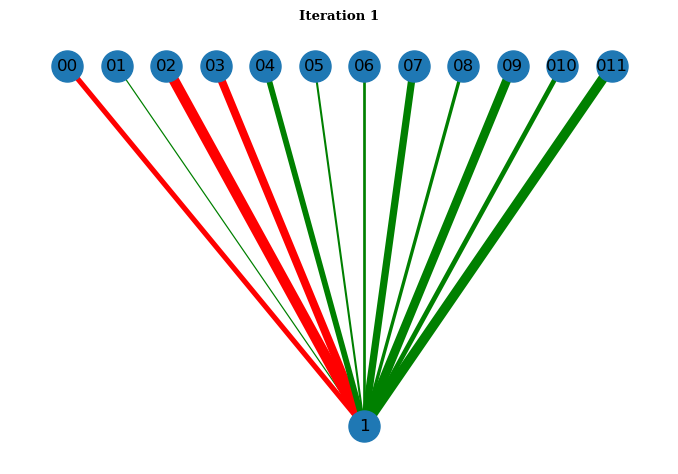

In [ ]:
import subprocess
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from matplotlib import rc

plt.rc("font", family="serif", size=8)

WIDTH = 8.5  # inches (from ICML style file)
HEIGHT = 8.5 / 1.5  # golden ratio
sample = 1

rc("font", family="serif", size=8)
usetex = not subprocess.run(["which", "pdflatex"]).returncode
usetex = False
rc("text", usetex=usetex)
if usetex:
    rc("text.latex", preamble=r"\usepackage{times}")

N = 12

fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))
G, pos = build_1L_graph(N)
magnifier = 50
weights = 0


def update(frame):
    global weights

    # update variables
    ax.clear()
    old_weights = weights
    # weights = attns[10 * frame].mean(axis=0)
    weights = attns[10 * frame, sample]
    T = 0.01
    weights = np.exp(weights / T)
    weights /= np.sum(weights)

    # color edges according to updates
    diff = weights - old_weights
    colors = ["green" if d > 0 else "red" for d in diff]

    # draw the updated graph
    nx.draw(
        G,
        pos,
        width=magnifier * weights,
        with_labels=True,
        edge_color=colors,
        node_size=500,
        ax=ax,
    )
    ax.set_title(f"Iteration {frame+1}", fontweight="bold")


ani_length = 1_000
ani = animation.FuncAnimation(fig, update, frames=ani_length, repeat=False)
# ani.save("test.gif", writer="imagemagick", fps=5)
ani.save(f"test_{sample}.mp4", writer="ffmpeg", fps=10)